## Изучение данных из файлов

Описание задания:

> **Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В  распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.**

**Описание тарифов**
- Тариф «Смарт»
Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля

сообщение: 3 рубля

1 Гб интернет-трафика: 200 рублей

- Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей


**Примечание:**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Импортируем нужные нам библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import numpy as np
import datetime as dt
from scipy import stats as st
pd.options.mode.chained_assignment = None

Прочитаем таблицы с данными

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv') #, sep='\\t',engine='python')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

Посмотрим типы колонок, их заполненность и тип данных.

### Звонки

In [3]:
df_calls.info()
display(df_calls['duration'].describe())
df_calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [4]:
df_calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

#### Вывод

- На первый взгляд всё нормально, пропусков в данных нет, нулевые значения - пропущенные вызовы, их мы оставим;
- Стоит перевести столбец по длительности разговора в целочисленный вид с округлением вверх до минут *по условиям оператора*.
- Перевести дату в формат datetime.

### Интернет

In [5]:
df_internet.info()
display(df_internet['mb_used'].describe())
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


#### Вывод

- Пропущенных значений нет;
- Стоит переименовать столбец *Unnamed:0*, а так же привести к строчному виду;
- Перевести мегабайты к целочисленному виду с округлением вверх до гигабайт.
- Перевести дату в формат datetime.

### Сообщения

In [6]:
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


#### Вывод

- Перевести дату в формат datetime.

### Тарифы

In [7]:
df_tariffs.info()
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Вывод

- Ошибок, пропусков нет.

### Информация о пользователях

In [8]:
df_users.info()
display(df_users['age'].describe())
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


#### Вывод

- Пропуски есть в одном столбце с датой прекращения тарифа, он для дальнейшего анализа не нужен - оставим как есть;
- Надо будет поменять столбцы с городами и ФИО пользователей на строчный регистр;
- Перевести дату в формат datetime.

## Предобработка данных

### Пользователи

In [9]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [10]:
df_users.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

In [11]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['reg_date'] = df_users['reg_date'].dt.month
df_users.rename(columns={'reg_date':'reg_month'})

,user_id,age,churn_date,city,first_name,last_name,reg_month,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,5,ultra
1,1001,41,NaN,Москва,Иван,Ежов,11,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,6,smart
3,1003,23,NaN,Москва,Белла,Белякова,8,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,5,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,8,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,1,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,10,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,7,smart


In [12]:
df_users['city'] = df_users['city'].str.lower()
df_users['first_name'] = df_users['first_name'].str.lower()
df_users['last_name'] = df_users['last_name'].str.lower()

In [13]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,краснодар,рафаил,верещагин,5,ultra
1,1001,41,NaN,москва,иван,ежов,11,smart
2,1002,59,NaN,стерлитамак,евгений,абрамович,6,smart
3,1003,23,NaN,москва,белла,белякова,8,ultra
4,1004,68,NaN,новокузнецк,татьяна,авдеенко,5,ultra


In [14]:
df_users.churn_date.unique()

array([nan, '2018-10-05', '2018-12-18', '2018-11-21', '2018-10-03',
       '2018-10-14', '2018-12-09', '2018-12-11', '2018-12-26',
       '2018-08-31', '2018-12-03', '2018-12-23', '2018-11-07',
       '2018-12-16', '2018-12-20', '2018-11-30', '2018-12-21',
       '2018-08-17', '2018-09-02', '2018-10-04', '2018-11-13',
       '2018-11-22', '2018-10-28', '2018-11-26', '2018-11-27',
       '2018-11-16', '2018-10-27', '2018-12-30', '2018-09-27',
       '2018-12-25', '2018-12-14', '2018-12-24', '2018-09-26',
       '2018-10-25'], dtype=object)

### Звонки

Переведем все записи по длительности в минуты и сделаем их целочисленными.

In [15]:
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['call_date'] = df_calls['call_date'].dt.month
df_calls = df_calls.rename(columns = {'call_date':'month'})
df_calls.head()


,id,month,duration,user_id
0,1000_0,7,0,1000
1,1000_1,8,0,1000
2,1000_2,6,3,1000
3,1000_3,9,14,1000
4,1000_4,12,6,1000


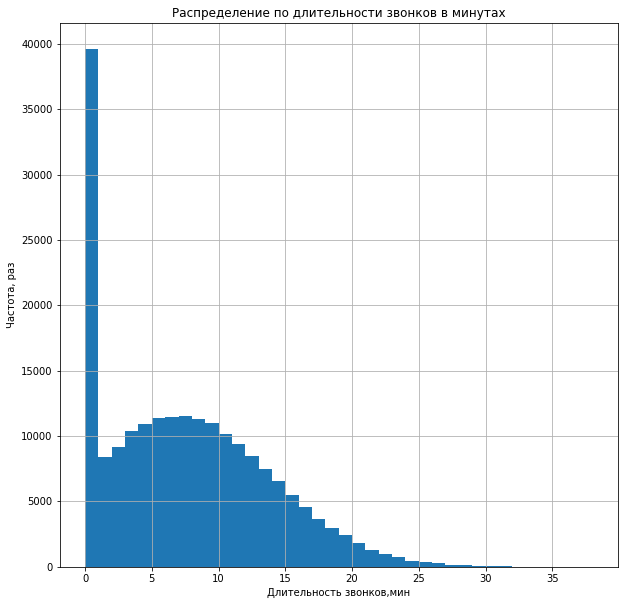

In [16]:
ax = df_calls['duration'].plot(kind = 'hist',
                               bins = 38, 
                               grid = True,
                               figsize = (10,10),
                               title = 'Распределение по длительности звонков в минутах')
ax.set_xlabel('Длительность звонков,мин')
ax.set_ylabel('Частота, раз');

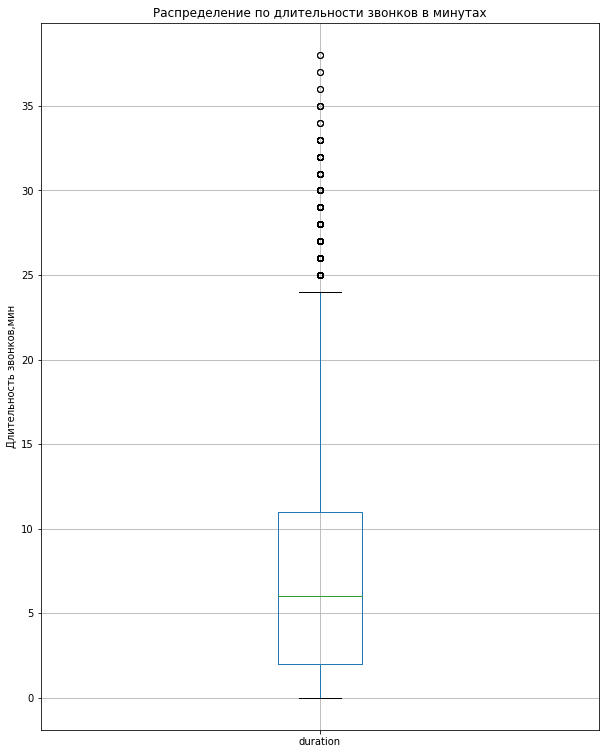

In [17]:
ax = df_calls['duration'].plot(kind = 'box',
                               grid = True,
                               figsize = (10,13),
                               title = 'Распределение по длительности звонков в минутах')
ax.set_ylabel('Длительность звонков,мин');

Очень большой пик при 0 минут разговора - это пропущенные звонки, сдвигающие распределение, уберем их из нового датафрейма и посмотрим ещё раз.

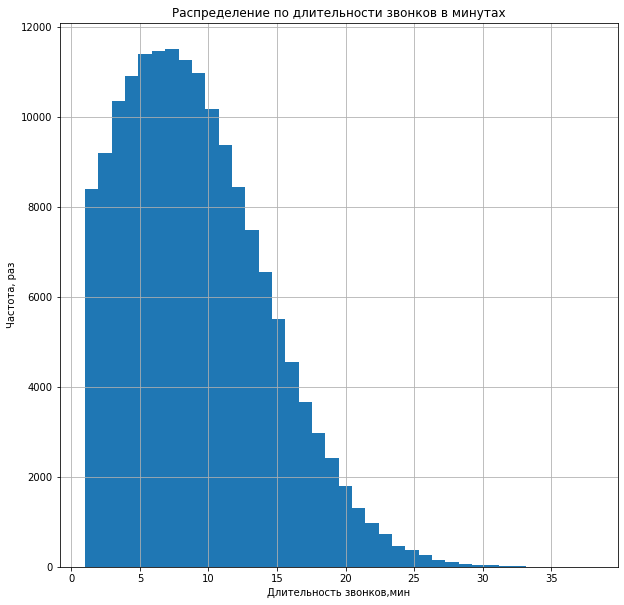

In [18]:
df_calls_f = df_calls.query('duration>0')
ax = df_calls_f['duration'].plot(kind = 'hist',
                               bins = 38, 
                               grid = True,
                               figsize = (10,10),
                               title = 'Распределение по длительности звонков в минутах')
ax.set_xlabel('Длительность звонков,мин')
ax.set_ylabel('Частота, раз');


Здесь мы видим чёткую картину пуассоновского распределения. Нули хоть и несут информацию о пропущенных звонках, но не учитываются при расчёте оплаты за услуги в конце месяца, поскольку для подсчета они не будут большой проблемой,а так же в этих строках могут быть другие полезные данные,оставим их.

### Интернет

Поскольку тарифы не подразумевают подсчёт мегабайт за отдельно взятую сессию, а только суммарно за месяц для каждого пользователя, стоит суммировать месячные значения для каждого пользователя в дальнейшем.

Так же поменяем дату 

In [19]:
df_internet ['session_date']= pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet['session_date'] = df_internet['session_date'].dt.month
df_internet = df_internet.rename(columns = {'session_date':'month'})

In [20]:
df_internet.head()

,Unnamed: 0,id,mb_used,month,user_id
0,0,1000_0,112.95,11,1000
1,1,1000_1,1052.81,9,1000
2,2,1000_2,1197.26,6,1000
3,3,1000_3,550.27,8,1000
4,4,1000_4,302.56,9,1000


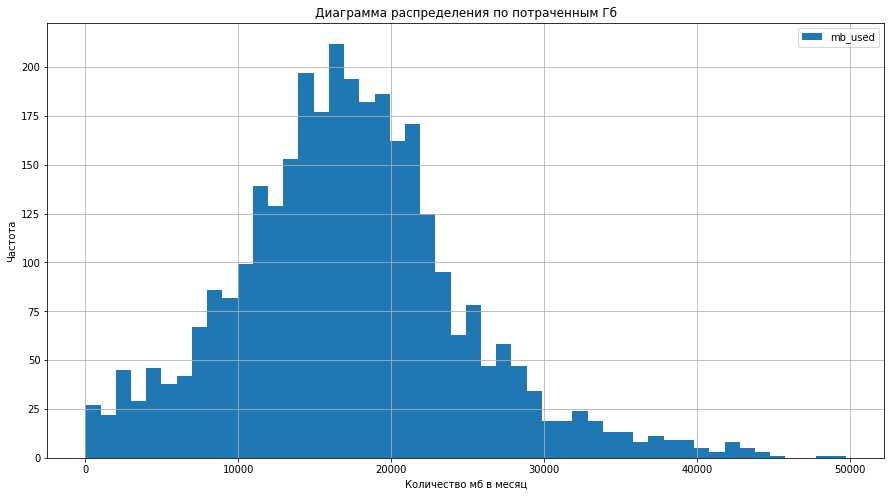

In [21]:
ax = df_internet.pivot_table(index=['user_id','month'], 
                         values = 'mb_used', 
                         aggfunc = 'sum').plot(kind = 'hist',
                                               bins = 50,
                                               grid = True,
                                               figsize = (15,8),
                                               title = 'Диаграмма распределения по потраченным Гб')
ax.set_xlabel('Количество мб в месяц')
ax.set_ylabel('Частота');

Распределение по виду близко к гауссовскому.Видно, что большинство пользователей тратят от 10 до 23 Гб в месяц.

### Сообщения

Аналогичные действия выполним для таблицы с информацией о потраченных пользователями сообщениях

In [22]:
df_messages ['message_date']= pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages['message_date'] = df_messages['message_date'].dt.month
df_messages = df_messages.rename(columns = {'message_date':'month'})

In [23]:
df_messages.head()

,id,month,user_id
0,1000_0,6,1000
1,1000_1,10,1000
2,1000_2,8,1000
3,1000_3,6,1000
4,1000_4,12,1000


### Вывод

- Выполнена проверка данных;
- Столбец по длительности разговора переведен в целочисленный вид с округлением вверх до минут *по условиям оператора*;
- Переведены даты в формат datetime;
- В колонках *'city','first_name', 'last_name'* изменены регистры на нижние;
- Мб в Гб переведем после объединения таблиц;
- Для удобства даты по всему датафрейму изменены на числовые месяца, чтобы по ним так же делать объединение.

## Объединение данных по услугам

Для начала, чтобы не убить ядро(что у меня получилось), сгруппируем данные по пользователям.
А так же сбросим индексы.

In [24]:
# Для таблицы со звонками,будем суммировать округленное количество минут
calls_pivot = df_calls.pivot_table(index = ['user_id','month'], values = 'duration',aggfunc = 'sum').reset_index()


# Для сообщений будем суммировать количество записей для каждого пользователя за месяц
messages_pivot = df_messages.pivot_table(index = ['user_id','month'], values = 'id',aggfunc = 'count').reset_index()


# здесь колонка id перестала нести смысл уникального идентификатора 
# и стала подсчётом сгруппированной суммы сообщений для каждого пользователя за месяц, таким образом, лучше ее переименовать.
messages_pivot = messages_pivot.rename(columns = {'id':'messages_count'})
internet_pivot = df_internet.pivot_table(index = ['user_id','month'], values = 'mb_used',aggfunc = 'sum').reset_index()

Далее будем последовательно объединять сгруппированные таблицы по двум колонкам:*'user_id' и 'month'* 

data_first = calls_pivot.merge(messages_pivot, on = ['user_id','month'], how = 'outer')\
                        .merge(internet_pivot, on = ['user_id','month'], how = 'outer')\
                        .merge(df_users,on = ['user_id'], how = 'left')

In [25]:
data_first = calls_pivot.merge(messages_pivot, on = ['user_id','month'], how = 'outer')\
                        .merge(internet_pivot, on = ['user_id','month'], how = 'outer')\
                        .merge(df_users,on = ['user_id'], how = 'left')


# Для объединения с датафреймом с тарифами надо так же изменить название колонки 'tariff_name' на 'tariff'
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})

data_services = data_first.merge(df_tariffs, on = 'tariff',how = 'left')

In [26]:
data_services.head(15)

,user_id,month,duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,2253.49,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,60.0,23233.77,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,75.0,14003.64,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,81.0,14055.93,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,57.0,14568.91,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
5,1000,10,350.0,73.0,14702.49,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
6,1000,11,338.0,58.0,14756.47,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
7,1000,12,333.0,70.0,9817.61,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
8,1001,11,430.0,NaN,18429.34,41,NaN,москва,иван,ежов,11,smart,50,15360,500,550,200,3,3
9,1001,12,414.0,NaN,14036.66,41,NaN,москва,иван,ежов,11,smart,50,15360,500,550,200,3,3


>Из-за объединения таблиц некоторые столбцы поменяли свой тип данных.

Надо вернуть тип данных для стоблцов 'month', 'duration', 'messages_count','mb_used'. Выдает наличие ошибки. Значит есть NaN, проверим это.

> Пропущенные значения в данных колонках говорят о том, что данная услуга не использовалась этим пользователем в отдельном месяце, заменим на нулевые значения.

In [27]:
data_services['month'] = data_services['month'].fillna(0)
data_services['duration'] = data_services['duration'].fillna(0)
data_services['messages_count'] = data_services['messages_count'].fillna(0)
data_services['mb_used'] = data_services['mb_used'].fillna(0)

И переведем в целочисленный вид. Так же предварительно округлим количество потраченных мб вверх.

In [28]:
data_services['month'] = data_services['month'].astype(int)
data_services['duration'] = data_services['duration'].astype(int)
data_services['messages_count'] = data_services['messages_count'].astype(int)
data_services['mb_used'] = (np.ceil(data_services['mb_used'])).astype(int)

In [29]:
data_services.head(15)

,user_id,month,duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159,22,2254,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172,60,23234,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340,75,14004,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408,81,14056,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466,57,14569,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
5,1000,10,350,73,14703,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
6,1000,11,338,58,14757,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
7,1000,12,333,70,9818,52,NaN,краснодар,рафаил,верещагин,5,ultra,1000,30720,3000,1950,150,1,1
8,1001,11,430,0,18430,41,NaN,москва,иван,ежов,11,smart,50,15360,500,550,200,3,3
9,1001,12,414,0,14037,41,NaN,москва,иван,ежов,11,smart,50,15360,500,550,200,3,3


Все данные собраны и выполнена их предобработка

In [30]:
# Сперва создадим столбец с Гб положенными по тарифу
def gb_included(mb_per_month_included):
    if mb_per_month_included == 30720:
        return 30
    if mb_per_month_included == 15360:
        return 15
data_services['gb_per_month_included'] = data_services['mb_per_month_included'].apply(gb_included)


# Так же создадим колонку с потраченными Гб в двоичной системе пересчёта мегабайт
def gb_spent (mb_used):
    return  int(np.ceil(mb_used/1024))
data_services['gb_spent'] = data_services['mb_used'].apply(gb_spent)

data_services.head(15)

,user_id,month,duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_spent
0,1000,5,159,22,2254,52,NaN,краснодар,рафаил,верещагин,...,ultra,1000,30720,3000,1950,150,1,1,30,3
1,1000,6,172,60,23234,52,NaN,краснодар,рафаил,верещагин,...,ultra,1000,30720,3000,1950,150,1,1,30,23
2,1000,7,340,75,14004,52,NaN,краснодар,рафаил,верещагин,...,ultra,1000,30720,3000,1950,150,1,1,30,14
3,1000,8,408,81,14056,52,NaN,краснодар,рафаил,верещагин,...,ultra,1000,30720,3000,1950,150,1,1,30,14
4,1000,9,466,57,14569,52,NaN,краснодар,рафаил,верещагин,...,ultra,1000,30720,3000,1950,150,1,1,30,15
5,1000,10,350,73,14703,52,NaN,краснодар,рафаил,верещагин,...,ultra,1000,30720,3000,1950,150,1,1,30,15
6,1000,11,338,58,14757,52,NaN,краснодар,рафаил,верещагин,...,ultra,1000,30720,3000,1950,150,1,1,30,15
7,1000,12,333,70,9818,52,NaN,краснодар,рафаил,верещагин,...,ultra,1000,30720,3000,1950,150,1,1,30,10
8,1001,11,430,0,18430,41,NaN,москва,иван,ежов,...,smart,50,15360,500,550,200,3,3,15,18
9,1001,12,414,0,14037,41,NaN,москва,иван,ежов,...,smart,50,15360,500,550,200,3,3,15,14


## Подсчёт выручки с пользователя

Посчитаем, сколько каждый клиент платит сверх тарифа в месяц, если у него имеются превышения по используемому пакету услуг.
Если превышения нет, соответственно, клиент платит за выбранный тариф.

In [31]:
def revenue (row):
    total = row['rub_monthly_fee'] 
    sms = (row['messages_count']-row['messages_included'])*row['rub_per_message']
    mins = (row['duration']-row['minutes_included'])*row['rub_per_minute']
    gbs = (row['mb_used']-row['mb_per_month_included'])/1024 
    gbs = np.ceil(gbs)*row['rub_per_gb']
    
    
    for i in [sms, mins, gbs]:
        if i > 0:
            total += i 
    return int(total)
    

In [32]:
data_services['revenue'] = data_services.apply(revenue,axis = 1)
data_services.head(15)

,user_id,month,duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_spent,revenue
0,1000,5,159,22,2254,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,3,1950
1,1000,6,172,60,23234,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,23,1950
2,1000,7,340,75,14004,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,14,1950
3,1000,8,408,81,14056,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,14,1950
4,1000,9,466,57,14569,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,15,1950
5,1000,10,350,73,14703,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,15,1950
6,1000,11,338,58,14757,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,15,1950
7,1000,12,333,70,9818,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,10,1950
8,1001,11,430,0,18430,41,NaN,москва,иван,ежов,...,50,15360,500,550,200,3,3,15,18,1150
9,1001,12,414,0,14037,41,NaN,москва,иван,ежов,...,50,15360,500,550,200,3,3,15,14,550


In [33]:
data_services['revenue'].value_counts()

1950    905
550     567
950      87
1150     80
1350     78
       ... 
2035      1
1527      1
2014      1
2004      1
2041      1
Name: revenue, Length: 778, dtype: int64

In [34]:
data_services['revenue'].describe()

count    3214.000000
mean     1529.076229
std       798.251091
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: revenue, dtype: float64

Всё отлично, нет отрицательных значений и значений меньше минимальной платы за тариф. Можно строить гистограммы для пользователей по тарифам и услугам.

## Анализ данных

Требуется описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? А так же посчитать среднее количество, дисперсию и стандартное отклонение и построить и описать диаграммы распределения.

Сделаем разбивку пользователей по тарифным планам.

Так же построим гистограммы для трех параметров для обоих тарифов:
   1) Длительности звонков;
   
   2) Потраченных смс;
   
   3) Потраченных Гб

In [35]:
df_ultra = data_services.query('tariff == "ultra"')
df_smart = data_services.query('tariff == "smart"')

In [36]:
df_ultra.head()

,user_id,month,duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_spent,revenue
0,1000,5,159,22,2254,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,3,1950
1,1000,6,172,60,23234,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,23,1950
2,1000,7,340,75,14004,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,14,1950
3,1000,8,408,81,14056,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,14,1950
4,1000,9,466,57,14569,52,NaN,краснодар,рафаил,верещагин,...,1000,30720,3000,1950,150,1,1,30,15,1950


### Длительность звонков

Сводная таблица по статистическим параметрам для длительности разговора

In [37]:
data_services.pivot_table(index= 'tariff', values= 'duration', aggfunc= ['var','describe'])

var describe                                                 \
             duration      25%    50%    75%   count     max        mean  min   
tariff                                                                          
smart    36219.315784    282.0  422.0  545.0  2229.0  1435.0  417.934948  0.0   
ultra   100873.633397    284.0  518.0  752.0   985.0  1673.0  526.623350  0.0   

                    
               std  
tariff              
smart   190.313730  
ultra   317.606098

Диаграмма распределения для длительности разговора по двум тарифным планам

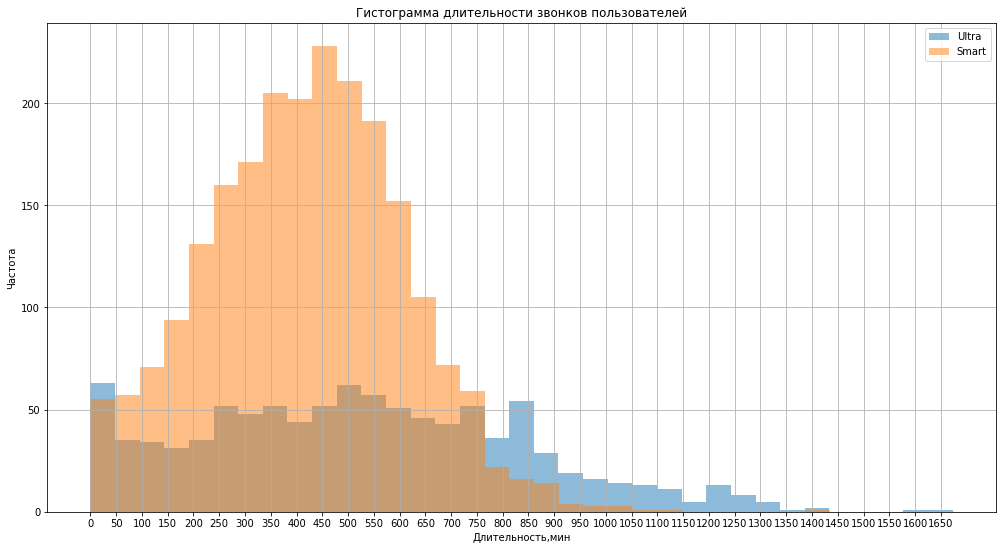

In [38]:
ax = (df_ultra
      .plot(
            kind = 'hist',
            y = 'duration',
            grid = True,
            figsize = (17,9),
            bins = 35,
            legend = True,
            alpha =0.5,
            label = 'Ultra',
     )
)

(df_smart
    .plot(
          kind = 'hist',
          y = 'duration',
          grid = True,
          ax=ax,
          figsize = (17,9),
          legend = True,
          bins =30,
          alpha =0.5,
          label = 'Smart',
          title = 'Гистограмма длительности звонков пользователей')
)
ax.set_xlabel('Длительность,мин')
ax.set_ylabel('Частота')
ax.set_xticks(np.arange(0, max(df_ultra['duration']), 50));


Количество пользователей тарифа Smart очевидно в несколько раз больше, нежели пользователей тарифа Ultra.
Исходя из гистограммы можно сказать следующее:
- Средняя сумма потраченных минут в месяц для пользователя тарифа **Smart** равна **417 минутам**, медиана равна **422**;
- Средняя сумма потраченных минут в месяц для пользователя тарифа **Ultra** равна **527 минутам**, медиана равна **518**;
- Большая часть пользователей тарифа **Smart** использует **от 300 до 600 минут**. Есть довольно большой процент пользователей  с превышениями по количеству минут в данном тарифе. Чуть меньше половины пользователей тратят в месяц больше 500 минут;
- Среди пользователей тарифа **Ultra** есть довольно большой свиду процент пропущенных вызовов длительностью 0 мин,однако высота этого пика объясняется тем, что в целом клиентов с данным тарифом меньше, чем с тарифом Smart, соответственно, количество вызовов пропущенных вызвов сильнее влияет на распределение;
- У пользователей тарифа **Ultra** основная часть распределения распологается между **300 и 900 минутами**, распределение довольно равномерное. Однако визуально пользователей,которые тратят **свыше 1000 мин** ( положенных тарифом), значительно меньше.




### Количество сообщений

Сводная таблица по статистическим параметрам для количества сообщений

In [39]:
data_services.pivot_table(index= 'tariff', values= 'messages_count', aggfunc= ['var','describe'])

var describe                                             \
       messages_count      25%   50%   75%   count    max       mean  min   
tariff                                                                      
smart      796.812958     10.0  28.0  51.0  2229.0  143.0  33.384029  0.0   
ultra     2285.266143      6.0  38.0  79.0   985.0  224.0  49.363452  0.0   

                   
              std  
tariff             
smart   28.227876  
ultra   47.804457

Диаграмма распределения для количества использованных смс по двум тарифным планам

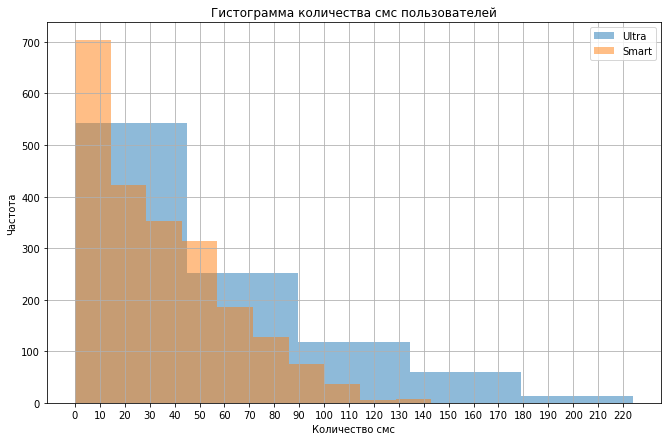

In [40]:
ax = (df_ultra
      .plot(
            kind = 'hist',
            y = 'messages_count',
            grid = True,
            figsize = (9,7),
            bins = 5,
            legend = True,
            alpha =0.5,
            label = 'Ultra',
     )
)

(df_smart
    .plot(
          kind = 'hist',
          y = 'messages_count',
          grid = True,
          ax=ax,
          figsize = (11,7),
          legend = True,
          alpha =0.5,
          label = 'Smart',
          title = 'Гистограмма количества смс пользователей')
)
ax.set_xlabel('Количество смс')
ax.set_ylabel('Частота')
ax.set_xticks(np.arange(0, max(df_ultra['messages_count']), 10));

Исходя из данных по отправленным сообщениям, можно сделать следующие выводы:
- В среднем пользователи тарифа **Smart** отпраляют в месяц **34 сообщения**, медиана - **28 смс**;
- Клиенты тарифа **Ultra** в среднем тратят в месяц **50 сообщений**, медиана - **38 смс**;
- Б*о*льшая часть пользователей в обоих тарифах **не пользуются сообщениями**. Это связано с тем, что на смену смс пришли различные мессенджеры, более удобные для переписки, в которых не требуется плата за каждое сообщения и которые расходуют интернет-трафик вместо этого;
- Для тарифа **Smart** пользователи отправляют по большей части **от 10 до 60 сообщений**. В меньшей степени людям требуется больше данного тарифом лимита, однако такие пользователи имеют место быть;
- Клиенты с тарифом **Ultra** тратят от **15 до 100 смс** в месяц, однако около 100 пользователей используют **больше 150 смс** в месяц.

### Количество потраченных гигабайт

Сводная таблица по статистическим параметрам для количества потраченных гигабайт

In [41]:
data_services.pivot_table(index= 'tariff', values= 'gb_spent', aggfunc= ['var','describe'])

var describe                                                    
         gb_spent      25%   50%   75%   count   max       mean  min       std
tariff                                                                        
smart   33.028705     13.0  17.0  20.0  2229.0  38.0  16.328847  0.0  5.747061
ultra   97.091686     12.0  19.0  27.0   985.0  49.0  19.494416  0.0  9.853511

Диаграмма распределения для количества использованных гигабайт по двум тарифным планам

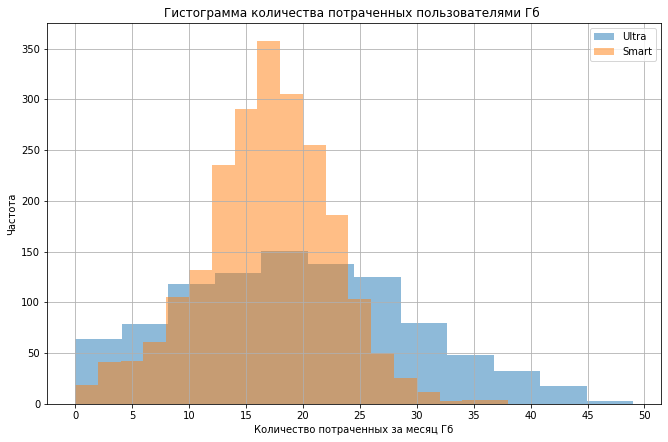

In [42]:
ax = (df_ultra
      .plot(
            kind = 'hist',
            y = 'gb_spent',
            grid = True,
            figsize = (9,7),
            legend = True,
            bins = 12,
            alpha =0.5,
            label = 'Ultra',
     )
)

(df_smart
    .plot(
          kind = 'hist',
          y = 'gb_spent',
          grid = True,
          ax=ax,
          figsize = (11,7),
          legend = True,
          alpha =0.5,
          bins = 19,
          label = 'Smart',
          title = 'Гистограмма количества потраченных пользователями Гб ')
)
ax.set_xlabel('Количество потраченных за месяц Гб')
ax.set_ylabel('Частота')
ax.set_xticks(np.arange(0, max(df_ultra['gb_spent']+5), 5));

Получив данные графики распределения, можно сделать следующие выводы:
- В среднем пользователи тарифа **Smart** тратят **17 Гб** в месяц, медиана - **17 Гб**;
- В среднем пользователи тарифа **Ultra** расходуют **20 Гб** в месяц, медиана - **19 Гб**;
- Основная часть пользователей тарифа **Smart** тратит **от 12 до 24 Гб** в месяц,количество людей, которые тратят **больше 30 Гб** в месяц минимально;
- Основная часть пользователей тарифа **Ultra** тратит **от 10 до 33 Гб** в месяц, однако доля пользователей, количество потраченных Гб в месяц находится в диапазоне **от 25 до 45** значительно выше,нежели у клиентов тарифа **Smart**;
- Пользователи тарифа **Ultra** не тратят **больше 50 Гб**.


## Проверка гипотез

Далее мы будем проверять гипотезы о разнице в выручке с пользователей разных тарифов и разных городов. Требуется принять или отвергнуть следующие гипотезы:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

 Для подсчёта мы будем пользоваться Гипотезой о равенстве средних двух генеральных совокупностей,т.к.:

- Генеральные совокупности не зависят друг от друга.
- Выборочные средние должны быть нормально распределены (что не играет большой роли,так как количество клиентов больше 200 для каждой совокупности,работает ЦПТ);
- Дисперсии рассматриваемых генеральных совокупностей должны быть равны, однако  если выборки достаточно велики (30 и больше значений) и равны по размеру между собой, такой подход оправдан: симуляции, проведённые учёными, показывают, что даже если дисперсии на самом деле не равны, то тест редко ошибается.

### Средняя выручка пользователей тарифов «Ультра» и «Смарт»

Для начала разберемся с первой теорией о различии в выручках для пользователей тарифов Ultra и Smart.
Сформулируем нулевыую и альтернативную теорию.


**H0**: средняя выручка с пользователей тарифов Ultra и Smart **одинаковая**;

**H1**: средняя выручка с пользователей тарифов Ultra и Smart **различается**.

In [43]:

# Для сравнения возьмем массив с выручками двух тарифов
ultra = df_ultra['revenue']
smart = df_smart['revenue']

alpha = .01 #уровень статистической значимости

#Проведем двухстороннюю проверку гипотезы о равенстве средних двух массивов

results = st.ttest_ind(
    ultra, 
    smart,
    equal_var = False) #учет того, что выборки не одинаковые по размеру

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


> Таким образом, можем сказать, что средняя выручка у этих двух тарифов **отличается**,а так же принять **альтернативную гипотезу верной**.

In [44]:
# Можно так же буквально посмотреть разницу средних этих выборок. При их равенстве разница должна быть близкой к нулю.

df_dif_revenue =abs(df_ultra['revenue'].mean()-df_smart['revenue'].mean())
df_dif_revenue

780.1787535326896

### Средняя выручка пользователей в Москве и других городах

Теперь проверим вторую теорию о различиях между выручкой между Москвой и другими городами, для этого сформулируем новые гипотезы:

**H0**: средняя выручка с пользователей в Москве и других городах **одинаковая**;

**H1**: средняя выручка с пользователей в Москве и других городах **различается**.

In [45]:
# Для сравнения возьмем массивы с выручками двух вариантов город - Москва и другой 
msk = data_services.query('city == "москва"')['revenue']
other = data_services.query('city != "москва"')['revenue']

alpha = .01 #уровень статистической значимости

#Проведем двухстороннюю проверку гипотезы о равенстве средних двух массивов

results = st.ttest_ind(
    msk, 
    other,
    equal_var = False) #учет того, что выборки не одинаковые по размеру

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


In [46]:
df_dif_revenue =abs(msk.mean()-other.mean())
df_dif_revenue

21.777356858163785

> При уровне статистической значимости в .01 **не получилось отвергнуть нулевую гипотезу**. Таким образом можем сделать вывод, что с б**o**льшей долей вероятности выручки в Москве и в других городах **одинаковые**.

## Определение показателей тарифов

### Средняя выручка сверх тарифа

In [47]:
# Для определения средней выручки сверх тарифа посчитаем разницу между общей выручкой с пользователч и стоиомстью тарифа.
df_smart_overrev = (df_smart['revenue'] - df_smart['rub_monthly_fee']).mean()
display(f'Средняя выручка сверх тарифа Smart  составляет: {np.ceil(df_smart_overrev)} руб.')

df_ultra_overrev = (df_ultra['revenue'] - df_ultra['rub_monthly_fee']).mean()
display(f'Средняя выручка сверх тарифа Smart  составляет: {np.ceil(df_ultra_overrev)} руб.')

'Средняя выручка сверх тарифа Smart  составляет: 740.0 руб.'

'Средняя выручка сверх тарифа Smart  составляет: 121.0 руб.'

 > В среднем сверх тарифа Мегалайн больше зарабатывает на предоставлении услуг для пользователей Smart.

Построим график распределения для трат сверх нормы.

In [48]:
df_ultra_overr = (df_ultra['revenue'] - df_ultra['rub_monthly_fee'])
df_smart_overr = (df_smart['revenue'] - df_smart['rub_monthly_fee'])

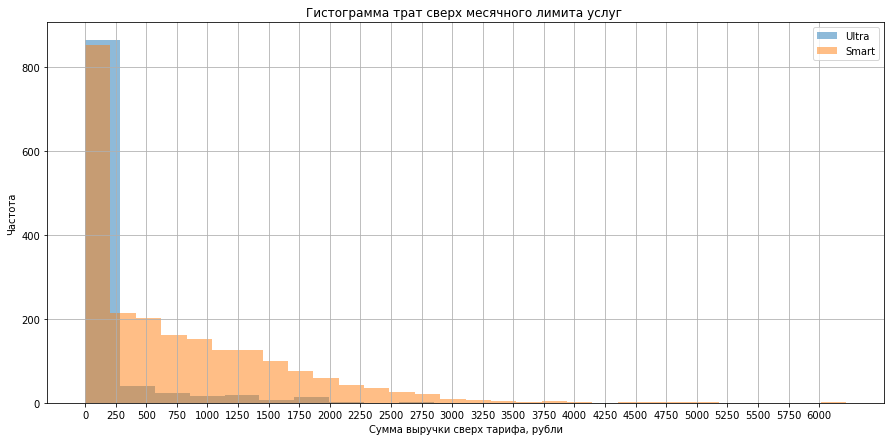

In [49]:
ax = (df_ultra_overr
      .plot(
            kind = 'hist',
            grid = True,
            figsize = (15,7),
            legend = True,
            #bins = 12,
            alpha =0.5,
            label = 'Ultra',
     )
)

(df_smart_overr
    .plot(
          kind = 'hist',
          grid = True,
          ax=ax,
          figsize = (15,7),
          legend = True,
          alpha =0.5,
          bins = 30,
          label = 'Smart',
          title = 'Гистограмма трат сверх месячного лимита услуг ')
)
ax.set_xlabel('Сумма выручки сверх тарифа, рубли')
ax.set_ylabel('Частота')
ax.set_xticks(np.arange(0, max(df_smart_overr+5), 250));

- Как мы видим, пользователи тарифа **Smart** гораздо **чаще и в больших объёмах** пользуются дополнительными смс,минутами и Гб;
- Значительная часть клиентов тратят **до 250р** сверх тарифа,что составляет практически **половину** суммы от тарифа **Smart** и всего лишь **13%** от тарифа **Ultra**;
- Так же довольно тяжелый хвост тянется и для пользователей тарифа **Smart** и **Ultra**, которые тратят доп.услуг на сумму вплоть до **2500р** и таких пользователей значительно больше в тарифе **Smart**.

### Суммарная среднемесячная выручка

Посмотрим, сколько в месяц в среднем проносит каждый тариф.

In [50]:
data_services.pivot_table(index = ['tariff','month'],values = 'revenue',aggfunc=['sum','mean'])

sum         mean
             revenue      revenue
tariff month                     
smart  1       24525   721.323529
       2       48001   827.603448
       3       89676  1164.623377
       4      107866   963.089286
       5      168849  1197.510638
       6      197459  1204.018293
       7      246014  1223.950249
       8      310340  1320.595745
       9      324986  1249.946154
       10     401267  1364.853741
       11     424403  1343.047468
       12     531965  1578.531157
ultra  1       17550  1950.000000
       2       47400  1975.000000
       3       74550  2014.864865
       4      110100  2001.818182
       5      138000  2059.701493
       6      171300  2039.285714
       7      192750  2118.131868
       8      222900  2083.177570
       9      232800  2024.347826
       10     254100  2065.853659
       11     280350  2092.164179
       12     297300  2138.848921

In [51]:
# Посмотрим среднюю выручку для каждого тарифа за год
ultr_rev = np.ceil(data_services.loc[data_services['tariff']=='ultra']['revenue'].mean())
smrt_rev = np.ceil(data_services.loc[data_services['tariff']=='smart']['revenue'].mean())


display('Среднемесячная выручка Ultra: {}'.format(ultr_rev))
display('Среднемесячная выручка Smart: {}'.format(smrt_rev))


'Среднемесячная выручка Ultra: 2071.0'

'Среднемесячная выручка Smart: 1290.0'

> Как мы видим, сверх нормы пользователи тарифа **Ultra редко** пользуются доп.услугами. При этом среднемесячная выручка с него фактически **больше,нежели с пользователя тарифа Smart**. Но только в абсолютном соотношении.
В среднем же относительном соотношении пользователи тарифа Smart в месяц тратят **в два с лишним раза больше** стоимости самого тарифа.

In [52]:
df_smart.revenue.sum()

2875351

In [53]:
df_ultra.revenue.sum()

2039100

### Процент доп.услуг в выручке для двух тарифов

Последнее, что осталось оценить, это процентный вклад доп.услуг в среднемесячной выручке для двух тарифов.

In [54]:
# Отберем записи с превышениями по количеству минут,смс и Гб отдельно.

calls = data_services.loc[data_services.duration > data_services.minutes_included]
sms = data_services.loc[data_services.messages_count > data_services.messages_included]
gb = data_services.loc[data_services.gb_spent > data_services.gb_per_month_included]

In [55]:
# Так же добавим столбец с подсчётом выручки за каждое из типов превышений тарифов

calls['calls_rev'] = ((calls.duration- calls.minutes_included)*calls.rub_per_minute).astype(int)
sms['sms_rev'] = ((sms.messages_count - sms.messages_included)*sms.rub_per_message).astype(int)
gb ['gb_rev'] = ((gb.gb_spent - gb.gb_per_month_included)*gb.rub_per_gb).astype(int)

In [56]:
# Теперь посчитаем процентный вклад каждой превышенной услуги в выручку

calls['calls_part'] = (calls.calls_rev/calls.revenue)*100
sms['sms_part'] =(sms.sms_rev/sms.revenue)*100
gb['gb_part']=(gb.gb_rev/gb.revenue)*100

#### Дополнительные минуты

Построим диаграммы по услугам

In [57]:
# Проверим,есть ли превышения по длительности у тарифа Ультра
uv = df_ultra.query('duration > minutes_included')
uv

,user_id,month,duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_spent,revenue


> Таких данных нет, тогда построим гистограмму для пользователей тарифа Смарт

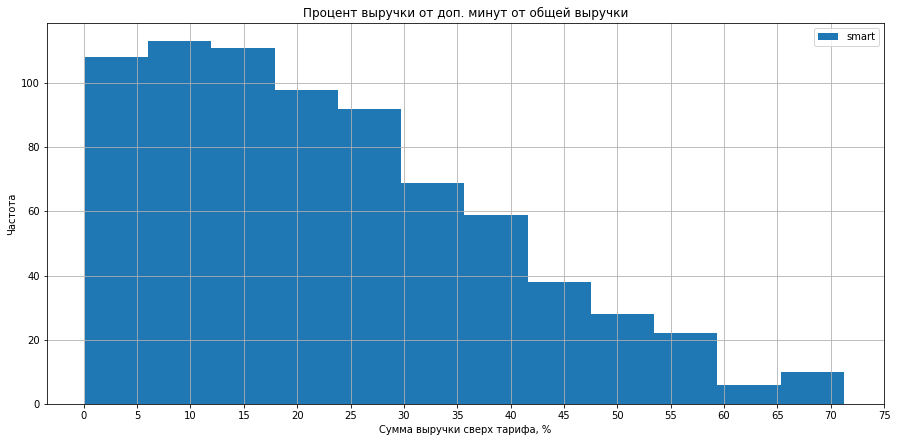

In [58]:
ax = calls['calls_part'].plot(kind = 'hist',
                              grid = True,
                              figsize = (15,7),
                              legend = True,
                              bins = 12,
                              title = 'Процент выручки от доп. минут от общей выручки',
                              label = 'smart')
     
ax.set_xlabel('Сумма выручки сверх тарифа, %')
ax.set_ylabel('Частота')
ax.set_xticks(np.arange(0, max(calls['calls_part']+5), 5));

- Как мы видим, процент дополнительных минут от общей выручки плавно снижается от **5 до 60 процентов**;
- Тем не менее б**О**льшая часть пользователей тарифа **Смарт** приносит прибыль вплоть **до 45%** от выручки в качестве полььзования доп.минутами;
- Пользователям тарифа **Ультра**, по-видимому, **хватает** предоставленных минут на месячное пользование.

#### Дополнительные смс

Теперь рассмотрим ситуацию с смс

In [59]:
sms_u = df_ultra.query('messages_count> messages_included')['user_id'].count()
sms_s = df_smart.query('messages_count> messages_included')['user_id'].count()
print(sms_u,sms_s)

0 564


Так же видим, что у пользователей тарифа **Ультра нет превышений** по количеству смс.

Рассмотрим выручку за доп.смс у полльзователей тарифа **Смарт**.

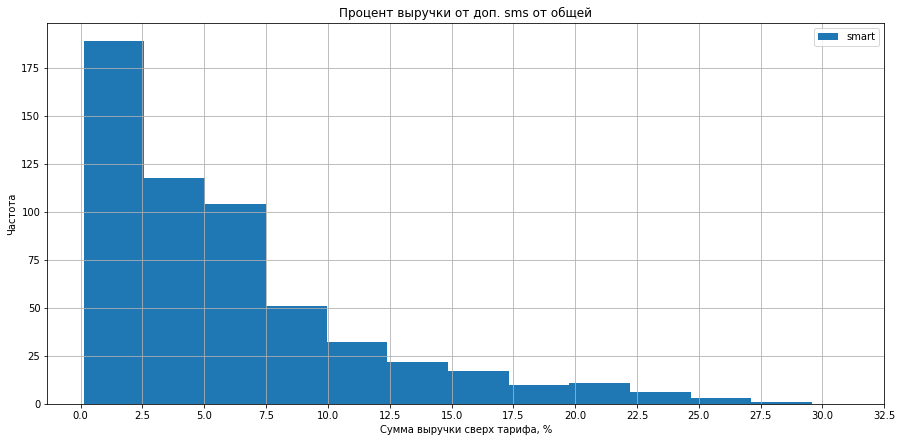

In [60]:
ax = sms['sms_part'].plot(kind = 'hist',
                              grid = True,
                              figsize = (15,7),
                              legend = True,
                              bins = 12,
                              title = 'Процент выручки от доп. sms от общей',
                              label = 'smart')
     
ax.set_xlabel('Сумма выручки сверх тарифа, %')
ax.set_ylabel('Частота')
ax.set_xticks(np.arange(0, max(sms['sms_part']+5), 2.5));

- Большая часть пользователей приносит **не более 7,5%** от всей среднемесячной выручки за счёт доп.смс,чаще всего - **до 2,5%**;
- Гораздо реже встречаются пользователи, которые приносят от **7,5 до 22%**

#### Дополнительные Гб

In [61]:
gb_u = df_ultra.query('gb_spent> gb_per_month_included')['user_id'].count()
gb_s = df_smart.query('gb_spent> gb_per_month_included')['user_id'].count()
print(gb_u,gb_s)

134 1304


В данном случае мы видим, что пользователи обоих тарифов с разной периодичностью тратят Гб сверх месячной нормы.

Построим гистограммы и сравним их

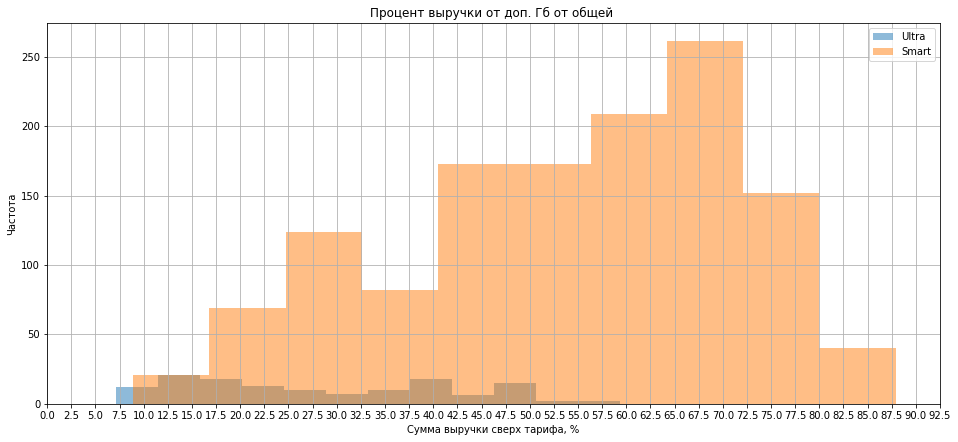

In [62]:
ax = (gb.query('tariff =="ultra"')['gb_part']
      .plot(
            kind = 'hist',
            grid = True,
            figsize = (16,7),
            legend = True,
            bins = 12,
            alpha =0.5,
            label = 'Ultra',
     )
)

(gb.query('tariff =="smart"')['gb_part']
    .plot(
          kind = 'hist',
          grid = True,
          ax=ax,
          figsize = (16,7),
          legend = True,
          alpha =0.5,
          bins = 10,
          label = 'Smart',
          title = 'Процент выручки от доп. Гб от общей ')
)
ax.set_xlabel('Сумма выручки сверх тарифа, %')
ax.set_ylabel('Частота')
ax.set_xticks(np.arange(0, max(gb['gb_part']+5), 2.5));

> ***Пользователи тарифа Smart***

- Распределение широкое;
- Большой процент тех, у кого плата за доп.Гб достигает от **40 до 80 %** от общей выручки,а так же от **25 до 33 %**;
- Из-за высокого значения отношения стоимости доп.Гб к цене самого тарифа, нет пользователей которые платят **менее 10%** от общей выручки.
- Встречаются пользователи, которые платят практически **80-87,5%** от общего за доп.Гб.

> ***Пользователи тарифа Ultra***

- Гораздо меньший процент пользователей данного тарифа переплачивает за доп.Гб. Естественно, это связано в первую очередь с тем, что в тариф включен гораздо бОльший объем интернет-трафика изначально;
- Стартовый процент переплаты за доп.Гб ниже,чем у пользователей тарифа Смарт, что связано с тем, что отношение цены за доп.Гб к общей выручке у них ниже, чем у тарифа Смарт;
- Распределение более всего напоминает биномиальное, встречаются стратифицированнеы группы с разным количеством процентых соотношений;
- Распределение находится в диапазоне от **7,5 до 50%**;
- Можно разделить их на условные приблизительно равные группы тех, кто тратит в районе **10-25%** и **37-50%**, однако вторых всё же меньше.

## Общий вывод

> ****Гипотезы****

 - Можно сделать вывод о том, что выручка с пользователей в Москве и других городах скорее **одинаковая**;
 - Однако, среднемесячная выручка с тарифов **различается**.

> ****Выводы по гистрограммам услуг****

- Пользователи тарифа **Смарт** тратят деньги на доп.услуги сверх тарифа гораздо чаще,нежели пользователи тарифа **Ультра**;
- Большую часть выручки сверх тарифа для обоих тарифов приносит **доп.Гб** - до **80%** в случае тарифа Смарт;
- **Дополнительные минуты** так же пользуются спросом у пользователей тарифа **Smart**, прибыль часто может составлять до **40%** от общей выручки;
- Пользователи обоих тарифов в гораздо меньшей степени пользуются дополнительными смс сверх месячного лимита и выручка в меньшей степени стостоит из переплаты по данному предложению - **до 10%**;
- Пользователи тарифа **Ультра** **не пользуются** доп.услугами по **минутам и смс** всерх тарифа;
- Общая среднемесячная выручка с пользователя тарифа **Ultra: 2072 рублей**;
- Общая среднемесячная выручка с пользователя тарифа **Smart: 1295 рублей**;
- Суммарная выручка с пользователей тарифа **Smart: 2 885 751 рублей**;
- Суммарная выручка с пользователей тарифа **Ultra: 2 040 000 рублей**;